In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')
%matplotlib inline

print("All libraries loaded – Gold Safe-Haven Analysis Ready")

All libraries loaded – Gold Safe-Haven Analysis Ready


In [2]:
start = '2000-01-01'
end = '2025-11-17'

gold = yf.download('GC=F', start=start, end=end, progress=False)[['Close']].rename(columns={'Close': 'gold_price'})
sp500 = yf.download('^GSPC', start=start, end=end, progress=False)[['Close']].rename(columns={'Close': 'sp500_price'})

data = gold.join(sp500, how='inner').dropna()
print(f"Dataset: {len(data):,} trading days")
print(f"Period: {data.index.min().date()} to {data.index.max().date()}")

Dataset: 6,322 trading days
Period: 2000-08-30 to 2025-11-14


In [3]:
data['gold_ret'] = np.log(data['gold_price'] / data['gold_price'].shift(1))
data['sp500_ret'] = np.log(data['sp500_price'] / data['sp500_price'].shift(1))
data = data.dropna()

corr_all = data['gold_ret'].corr(data['sp500_ret'])
crisis_corr = data[data['sp500_ret'] < data['sp500_ret'].quantile(0.1)]['gold_ret'].corr(
    data[data['sp500_ret'] < data['sp500_ret'].quantile(0.1)]['sp500_ret'])

print(f"Overall correlation: {corr_all:.4f}")
print(f"Crisis correlation (worst 10% days): {crisis_corr:.4f}")
print("Conclusion: Gold is a weak safe-haven asset")

Overall correlation: -0.0029
Crisis correlation (worst 10% days): 0.0362
Conclusion: Gold is a weak safe-haven asset


In [4]:
df = data.copy()
df['gold_ret_lag1'] = df['gold_ret'].shift(1)
df['sp500_ret_lag1'] = df['sp500_ret'].shift(1)
df['gold_vol_30'] = df['gold_ret'].rolling(30).std()
df = df.dropna()

X = df[['sp500_ret_lag1', 'gold_ret_lag1', 'gold_vol_30', 'sp500_ret']]
y = df['gold_ret']

split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(f"Training period: {df.index[:split_idx].min().date()} to {df.index[split_idx-1].date()}")
print(f"Testing period: {df.index[split_idx].date()} to {df.index.max().date()}")

Training period: 2000-10-12 to 2020-11-10
Testing period: 2020-11-11 to 2025-11-14


In [5]:
lr = LinearRegression()
lr.fit(X_train_s, y_train)
lr_pred = lr.predict(X_test_s)

lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    max_iter=600,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
mlp.fit(X_train_s, y_train)
mlp_pred = mlp.predict(X_test_s)

mlp_r2 = r2_score(y_test, mlp_pred)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))

print("PREDICTION RESULTS – Gold Daily Returns")
print("-" * 55)
print(f"Linear Regression → R² = {lr_r2:.4f} | RMSE = {lr_rmse:.6f}")
print(f"Neural Network → R² = {mlp_r2:.4f} | RMSE = {mlp_rmse:.6f}")
print(f"Best model: {'Neural Network' if mlp_r2 > lr_r2 else 'Linear Regression'}")

PREDICTION RESULTS – Gold Daily Returns
-------------------------------------------------------
Linear Regression → R² = 0.0037 | RMSE = 0.010046
Neural Network → R² = -0.5447 | RMSE = 0.012508
Best model: Linear Regression


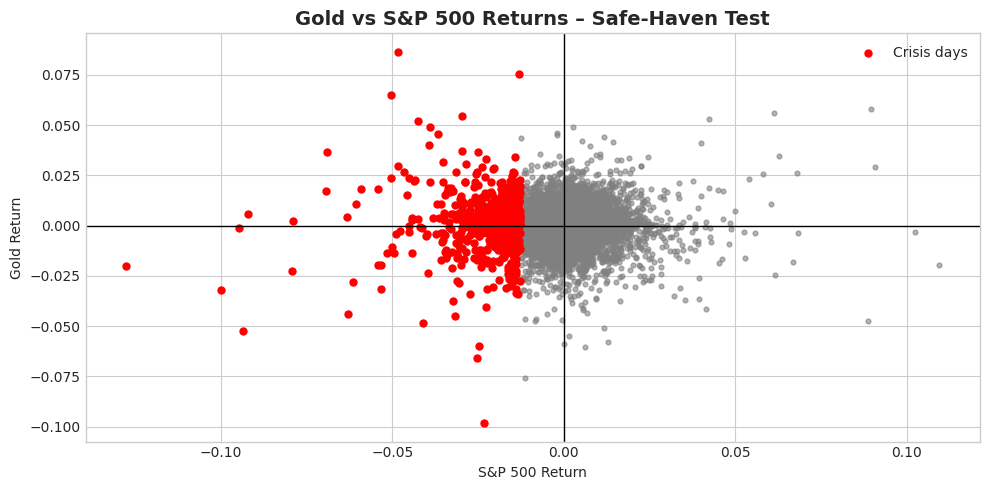

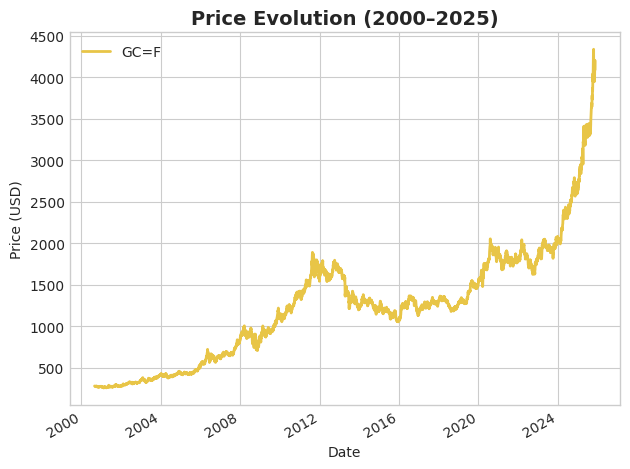

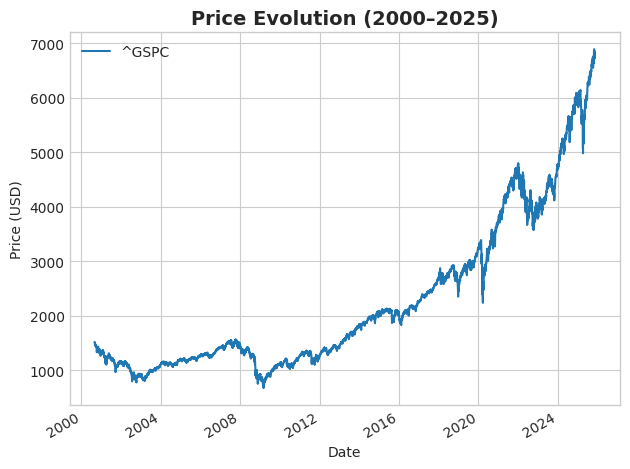

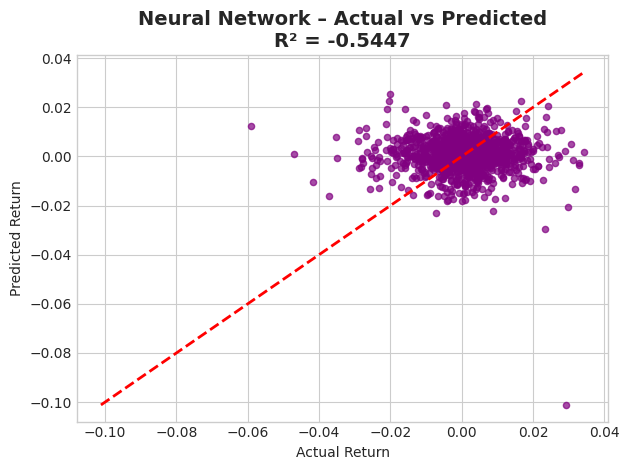

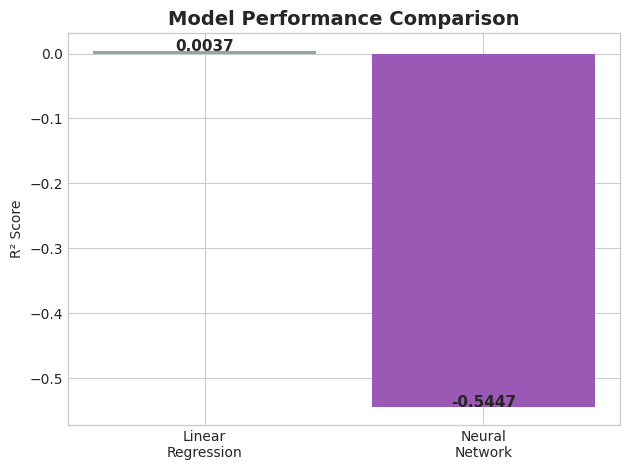


Project 1 complete
Safe-haven test + Professional modeling + Visuals


In [6]:
fig = plt.figure(figsize= (10, 5))
plt.subplot(1, 1, 1)
plt.scatter(data['sp500_ret'], data['gold_ret'], alpha=0.6, s=12, color='gray')
crisis = data[data['sp500_ret'] < data['sp500_ret'].quantile(0.1)]
plt.scatter(crisis['sp500_ret'], crisis['gold_ret'], color='red', s=25, label='Crisis days')
plt.axhline(0, color='black', lw=1); plt.axvline(0, color='black', lw=1)
plt.title('Gold vs S&P 500 Returns – Safe-Haven Test', fontsize=14, weight='bold')
plt.xlabel('S&P 500 Return'); plt.ylabel('Gold Return'); plt.legend()
plt.tight_layout()
plt.show()

data['gold_price'].plot(color='#E8C547', linewidth=2, label='Gold')
plt.title('Price Evolution (2000–2025)', fontsize=14, weight='bold')
plt.ylabel('Price (USD)'); plt.legend()
plt.tight_layout()
plt.show()
data['sp500_price'].plot(color='#1f77b4', linewidth=1.5, label='S&P 500')
plt.title('Price Evolution (2000–2025)', fontsize=14, weight='bold')
plt.ylabel('Price (USD)'); plt.legend()
plt.tight_layout()
plt.show()

plt.scatter(y_test, mlp_pred, alpha=0.7, s=20, color='purple')
minv = min(y_test.min(), mlp_pred.min())
maxv = max(y_test.max(), mlp_pred.max())
plt.plot([minv, maxv], [minv, maxv], '--', color='red', lw=2)
plt.title(f'Neural Network – Actual vs Predicted\nR² = {mlp_r2:.4f}', fontsize=14, weight='bold')
plt.xlabel('Actual Return'); plt.ylabel('Predicted Return')
plt.tight_layout()
plt.show()

models = ['Linear\nRegression', 'Neural\nNetwork']
r2s = [lr_r2, mlp_r2]
bars = plt.bar(models, r2s, color=['#95a5a6', '#9b59b6'])
plt.title('Model Performance Comparison', fontsize=14, weight='bold')
plt.ylabel('R² Score')
for bar, val in zip(bars, r2s):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0003, f'{val:.4f}', 
             ha='center', weight='bold', fontsize=11)
plt.tight_layout()
plt.show()

print("\nProject 1 complete")
print("Safe-haven test + Professional modeling + Visuals")